In [78]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import db_settings
import pyexasol
from pathlib import Path
import warnings
import csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
print(os.getcwd())

c:\Users\janja\Desktop\GitHub\lidar-vegetation-data


In [79]:
def get_class(id):
    family = dict_families[dict_gattung[id]['ID_FAMILIE']]
    order = dict_order[family['ID_ORDNUNG']]
    c = order['ID_KLASSE']
    return c
    

In [80]:
db =db_settings.db(autocommit=False)


In [81]:
req_families = """SELECT * FROM lidar_proj.familien"""
req_order = """SELECT * FROM lidar_proj.ordnungen"""
req_class = """SELECT * FROM lidar_proj.klassen"""
req_gattung = """SELECT * FROM lidar_proj.gattungen"""

df_families = db.export_to_pandas(req_families)
df_order = db.export_to_pandas(req_order)
df_class = db.export_to_pandas(req_class)
df_gattung = db.export_to_pandas(req_gattung)

df_families.set_index("ID", drop=True, inplace=True)
df_order.set_index("ID", drop=True, inplace=True)
df_class.set_index("ID", drop=True, inplace=True)
df_gattung.set_index("ID", drop=True, inplace=True)

In [82]:
global dict_gattung
global dict_families
global dict_order
global dict_class

dict_gattung =df_gattung.to_dict(orient="index")

dict_families =df_families.to_dict(orient="index")
dict_order =df_order.to_dict(orient="index")
dict_class =df_class.to_dict(orient="index")
print(dict_gattung[1])


{'LAT_NAME': 'Abies', 'DT_NAME': ' \tTannen ', 'ID_FAMILIE': 1.0}


In [83]:
#luckup klasse
gattungs_id = 3
print(dict_gattung[gattungs_id])
family = dict_families[dict_gattung[gattungs_id]['ID_FAMILIE']]
print(family)
order = dict_order[family['ID_ORDNUNG']]
print(order)
c = dict_class[order['ID_KLASSE']]
print(c)


{'LAT_NAME': 'Aesculus', 'DT_NAME': ' \tRosskastanien  ', 'ID_FAMILIE': 2.0}
{'LAT_NAME': 'Sapindaceae', 'DT_NAME': ' Seifenbaumgewächse ', 'ID_ORDNUNG': 4}
{'LAT_NAME': 'Sapindales', 'DT_NAME': 'Seifenbaumartige ', 'ID_KLASSE': 1}
{'LAT_NAME': 'Magnoliopsida', 'DT_NAME': ' Bedecktsamer'}


In [107]:
csv_folder ='clusters/dbscan'
extension = '*.csv' 
data_list = []
for file in Path(csv_folder).glob(extension):
        df = pd.read_csv(file)
        data_list.append(df)
print(len(data_list), " files imported")
individuals = []
for df in data_list:     
        cluster_ids = np.unique(np.array(df['Cluster_ID']).astype(int))
        for id in cluster_ids:
                df_split =df[df['Cluster_ID'] == id]
                individuals.append(df_split)
data =[]
labels = []
max_points = 0
for individuum in individuals:
        id = np.unique(np.array(individuum['Cluster_ID']).astype(int))[0]
        gattung = np.unique(np.array(individuum['GATTUNGS_ID']).astype(int))[0]
        xyz = list(np.array([individuum['x'],individuum['y'],individuum['z']]).transpose())
        #wieviele punkte hat die größte Punktwolke
        if len(xyz) > max_points:
                max_points = len(xyz)
        data.append(xyz)
        labels.append(gattung)


#set labels to class-labels
labels = np.array(list(map(get_class, labels)))

#mappimg ginko as conidera
labels = np.array(list(map(lambda x: 2 if x==3 else x, labels)))

print(labels)
print(len(labels), " individuums in train/test-set")

7  files imported
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
173  individuums in train/test-set


In [108]:
#adding dummy points:
data_with_add_points = []
for d in data:
    while len(d) <max_points:
        d.append([0,0,0])
    data_with_add_points.append(d)

In [109]:
labels = np.array(labels)
data_with_add_points = np.array(data_with_add_points)
print(len(labels))
X_train, X_test, y_train, y_test = train_test_split(data_with_add_points, labels, test_size=0.33, random_state=42)
print(X_train.shape, len(y_train))


173
(115, 304670, 3) 115


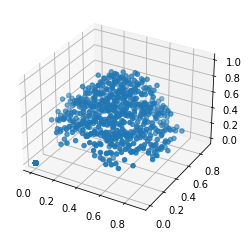

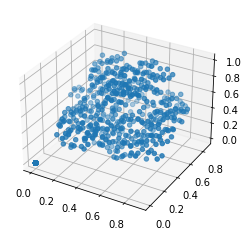

In [103]:
for r in random.choices(X_train, k=2):
    xs, ys, zs = r.transpose()
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs,ys,zs)
    plt.show()

In [115]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train[0])
f = pca.transform(X_train[0])
print(f)

[[ 0.3550947   0.10993326]
 [ 0.34989838  0.11975355]
 [ 0.32876914  0.08222241]
 ...
 [-0.01244238 -0.00145226]
 [-0.01244238 -0.00145226]
 [-0.01244238 -0.00145226]]


In [106]:
#svm linear kernel
print(X_train.shape)
print(y_train.shape)
svc_linear = SVC(kernel='linear', probability=True)
svc_linear.fit(X_train.transpose(), y_train)
#print_accuracy(svc_linear.predict)


(115, 304670, 3)
(115,)


ValueError: Found array with dim 3. Estimator expected <= 2.

In [56]:
#Support vector machine with a radial basis function kernel

svc_linear = SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, y_train)
print_accuracy(svc_linear.predict)


ValueError: Found array with dim 3. Estimator expected <= 2.

In [60]:
#Logistic regression
linear_lr = LogisticRegression()
linear_lr.fit(X_train, y_train)
accuracy_score(linear_lr.predict)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [47]:
#decision tree 1:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict([[2., 2.]])
clf.predict_proba(X_test)
clf.score(X_test, y_test)

tree.plot_tree(clf)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (103,) + inhomogeneous part.

In [ ]:
#decission tree 2:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree = decision_tree.fit(x_train, y_train)

In [ ]:
#random forest:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)

In [ ]:
#k-nearest neigbour
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

print_accuracy(knn.predict)